In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip

from collections import defaultdict

In [2]:
data_fn = "data/data.pkl.gzip"
with gzip.open(data_fn) as f:
    data = pickle.load(f)

In [34]:
count = defaultdict(int)
for action in data['action']:
    id = action_to_id(action)
    id = ', '.join(id)
    count[id] += 1

In [5]:
x = 0
for key, values in count.items(): x += values
assert x == len(data['action'])

In [6]:
N = len(data['action'])
for key, value in count.items():
    print(key, value / N)

NOTHING, NOTHING, NOTHING 0.2684
NOTHING, ACCELERATE, NOTHING 0.3504
LEFT, NOTHING, NOTHING 0.15955
RIGHT, NOTHING, NOTHING 0.09625
NOTHING, NOTHING, BREAK 0.03425
LEFT, NOTHING, BREAK 0.0531
RIGHT, ACCELERATE, NOTHING 0.0151
LEFT, ACCELERATE, NOTHING 0.0169
RIGHT, NOTHING, BREAK 0.00605


<BarContainer object of 9 artists>

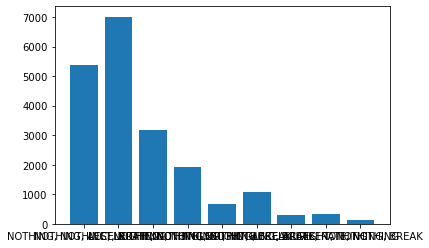

In [9]:
plt.bar(count.keys(), count.values())

In [3]:
def action_to_id(a, tol=1e-3):
    if abs(a[0] - 0) < tol:    a_1 = "NOTHING"
    elif abs(a[0] - 1) < tol:  a_1 = "RIGHT"
    elif abs(a[0] + 1) < tol:  a_1 = "LEFT"
    else:                      a_1 = ""

    if abs(a[1] - 1) < tol:     a_2 = "ACCELERATE"
    elif abs(a[1] - 0) < tol:   a_2 = "NOTHING"
    else:                       a_2 = ""

    if abs(a[2] - 0) < tol:       a_3 = "NOTHING" 
    elif abs(a[2] - 0.2) < tol:   a_3 = "BREAK"
    else:                         a_3 = ""

    return ', '.join([a_1, a_2, a_3])

In [5]:
d = {}  
  
# Each setting corresponds to a specific action 
# Here they are labeled arbitrarily because I wasnt sure if theyre exactly right
rest = 'NOTHING, NOTHING, NOTHING' 
right = 'RIGHT, NOTHING, NOTHING'
acc = 'NOTHING, ACCELERATE, NOTHING'
left = 'LEFT, NOTHING, NOTHING'
brake = 'NOTHING, NOTHING, BREAK'
left_brake = 'LEFT, NOTHING, BREAK'
left_acc = 'LEFT, ACCELERATE, NOTHING'
right_brake = 'RIGHT, NOTHING, BREAK'
right_acc = 'RIGHT, ACCELERATE, NOTHING'

# Adding values to each key in the dictionary
d[rest] = 0
d[right] = 3
d[acc] = 1
d[left] = 4
d[brake] = 2
d[left_brake] = 8
d[left_acc] = 7
d[right_brake] = 6
d[right_acc] = 5

In [4]:
def frame_to_arr(frame):
  val = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
  return np.reshape(val, (96**2))

In [6]:
df_array = []
for i in range(len(data['state'])):
  df_array.append(frame_to_arr(data['state'][i]))

label_array = []
for i in range(len(data['action'])):
  label_array.append( d[action_to_id(data['action'][i])] )

In [11]:
train = pd.DataFrame(df_array)
train.insert(0, 'label', label_array)

In [12]:
from sklearn.model_selection import train_test_split

val_pct = 0.1
X = train.drop('label', 1)
y = train.label
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_pct)

In [13]:
#The describe method returns a dataframe with features as columns and distributional stats as rows
#hint: use the dataframe.describe() and drop() methods and this can be done in 2 lines
def get_no_variance_features(df):
    '''
    Input: a data frame
    Ouput: a list of features with no variance
    '''
    desc_df = df.describe()
    return desc_df.loc['std'][(desc_df.loc['std']==0)].index.values

drop_list = get_no_variance_features(X_train)

X_train_filt = X_train.drop(drop_list, 1)
X_val_filt = X_val.drop(drop_list, 1)

X_train.shape, X_train_filt.shape

((18000, 9216), (18000, 8372))

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#Next let's build the model
ova1 = OneVsRestClassifier(LogisticRegression(max_iter=10000))

In [22]:
from sklearn import preprocessing
StdScl = preprocessing.StandardScaler()
X_scaled = StdScl.fit_transform(X_train_filt)

In [23]:
ova1.fit(X_scaled, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000))

In [26]:
#First execute this function
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc = np.diag(cm).sum() / float(cm.sum())
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('{},Acc={}'.format(title, acc))
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
X_val_scaled = StdScl.transform(X_val_filt)

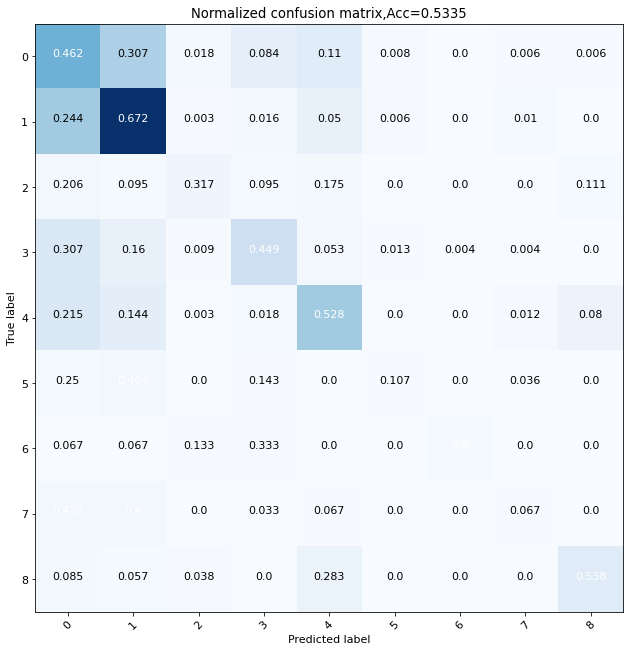

In [165]:
from sklearn.metrics import confusion_matrix

#Next, predict the class on validation data and generate the confusion_matrix
preds_ova = ova1.predict(X_val_scaled)
cm = confusion_matrix(y_val, preds_ova, labels=range(9))

#Now use the function above to plot it
np.set_printoptions(precision=3)
plt.rcParams.update({'text.color': 'black'})
plt.figure(figsize = (9,9))
plot_confusion_matrix(cm, classes=range(9), normalize=True, cmap =plt.cm.Blues,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(X_scaled, y_train)

RandomForestClassifier(n_estimators=200)

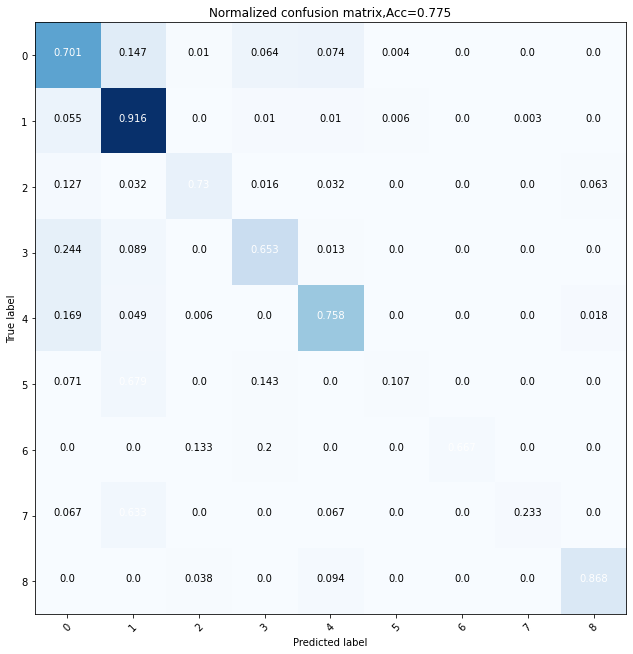

In [156]:
#Get the predictions and a confusion matrix, and plot like was done above
preds_rf = rf.predict(X_val_scaled)
cm_rf = confusion_matrix(y_val, preds_rf, labels=range(9))

np.set_printoptions(precision=3)
plt.rcParams.update({'font.size': 10})
plt.figure(figsize = (9,9))
plot_confusion_matrix(cm_rf, classes=range(9), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [81]:
from joblib import dump, load
dump(ova1, 'ova1.joblib') 

['ova1.joblib']

In [82]:
clf = load('ova1.joblib') 
clf

OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000))

In [83]:
clf.predict(X_val_scaled[0:2])

array([0, 3], dtype=int64)

In [128]:
preds_ova[0:5]

array([0, 3, 0, 6, 0], dtype=int64)

In [103]:
temporary = []
val1 = np.dot(data['state'][0][...,:3], [0.2125, 0.7154, 0.0721])
val1 = np.reshape(val1, (96**2))
va1l = val1.reshape(1,-1)
clf.predict(val1[0][0:8372])

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [130]:
temporary = []
for i in range(len(data['state'][0:5])):
  temporary.append(frame_to_arr(data['state'][i]))

In [131]:
copy = np.delete(copy, np.s_[8372:], 1)
np.shape(copy)

(5, 8372)

In [132]:
clf.predict(copy)

array([4, 7, 7, 4, 7], dtype=int64)